In [75]:
!pip install pytorch-tabnet scikit-learn imbalanced-learn matplotlib seaborn xgboost

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from pytorch_tabnet.tab_model import TabNetClassifier

import warnings
warnings.filterwarnings('ignore')

In [77]:
df = pd.read_csv('obesity_data_with_status_50000.csv')
df.head()

,Age,Gender,Height_cm,Weight_kg,BMI,Physical_Activity_Level,Diet_Type,Smoking_Habits,Alcohol_Consumption,Family_History_Obesity,Blood_Pressure,Cholesterol_Levels,Education_Level,Income_Level,Geographical_Region,Obesity_Status
0,56,0,172.005936,68.686179,23.215738,4,1,2,0,1,Hypertension Stage 2,2,1,3,2,Normal weight
1,69,1,161.678497,79.937723,30.580688,2,0,0,0,0,Elevated,1,2,1,3,Obese
2,46,1,172.078597,99.707918,33.672545,4,1,1,1,0,Normal,3,2,3,2,Obese
3,32,1,176.845709,76.314302,24.401520,1,2,0,1,0,Normal,3,1,2,1,Normal weight
4,60,1,170.875161,84.397860,28.905039,2,1,0,2,1,Elevated,2,3,3,2,Overweight


In [78]:
df.shape

(50000, 16)

In [79]:
label_encoder = LabelEncoder()
df['Obesity_Status'] = label_encoder.fit_transform(df['Obesity_Status'])
df['Blood_Pressure'] = label_encoder.fit_transform(df['Blood_Pressure'])

In [80]:
def remove_outliers_zscore(df, column_names, threshold=3):
    z_scores = np.abs((df[column_names] - df[column_names].mean()) / df[column_names].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

continuous_columns = ['Height_cm', 'Weight_kg']
df_cleaned = remove_outliers_zscore(df, continuous_columns)

print(f"Data shape after outlier removal: {df_cleaned.shape}")

Data shape after outlier removal: (49744, 16)


In [81]:
scaler = StandardScaler()
df_cleaned[['Height_cm', 'Weight_kg']] = scaler.fit_transform(df_cleaned[['Height_cm', 'Weight_kg']])

#### obesity_labels
+     0: 'Underweight',
+     1: 'Normal Weight',
+     2: 'Overweight',
+     3: 'Obese'

+ calculated the class distribution of the target variable
+ applied scaling inversely proportional to class frequencies
+ meaning minority classes get higherweight
+ Classes with fewer instances are given a higher scaling factor, model to treat each class more equally during training

In [82]:
class_counts = df_cleaned['Obesity_Status'].value_counts()

scale_factor = class_counts.max() / class_counts

def augment_data(df, target_col, scale_factor):
    frames = []
    for label, factor in scale_factor.items():
        df_class = df[df[target_col] == label]
        df_class_replicated = pd.concat([df_class] * int(np.round(factor)), ignore_index=True)
        frames.append(df_class_replicated)

    df_augmented = pd.concat(frames).sample(frac=1).reset_index(drop=True)  # Shuffle the data
    return df_augmented

df_augmented = augment_data(df_cleaned, 'Obesity_Status', scale_factor)
print(f"New class distribution after augmentation:\n{df_augmented['Obesity_Status'].value_counts()}")

New class distribution after augmentation:
Obesity_Status
3    18308
0    17442
2    15094
1    12631
Name: count, dtype: int64


+ We computed class weights to ensure that the model doesn't favor majority classes
+ They modify the loss function so that errors on minority classes (e.g., underweight, obese) are penalized more heavily.

In [83]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: 0.9019894437677629, 1: 1.2594104308390022, 2: 1.0528909952606635, 3: 0.8714207264454381}


In [84]:
Q1 = df_augmented['Obesity_Status'].quantile(0.25)
Q3 = df_augmented['Obesity_Status'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_augmented[(df_augmented['Obesity_Status'] < lower_bound) | (df_augmented['Obesity_Status'] > upper_bound)]

print("Outliers in Obesity_Status column:", len(outliers))

Outliers in Obesity_Status column: 0


In [85]:
X = df_augmented.drop('Obesity_Status', axis=1)
y = df_augmented['Obesity_Status']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% validation, 15% test

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (44432, 15)
Validation set shape: (9521, 15)
Test set shape: (9522, 15)


In [86]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_val)
print(f"Logistic Regression Accuracy: {accuracy_score(y_val, y_pred_log_reg)}")

Logistic Regression Accuracy: 0.9160802436718832


In [87]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
print(f"Random Forest Accuracy: {accuracy_score(y_val, y_pred_rf)}")

Random Forest Accuracy: 1.0


In [88]:
# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)
print(f"SVM Accuracy: {accuracy_score(y_val, y_pred_svm)}")

SVM Accuracy: 0.997374225396492


In [89]:
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
print(f"XGBoost Accuracy: {accuracy_score(y_val, y_pred_xgb)}")

XGBoost Accuracy: 0.9982144732696145


+ Initialized the TabNet Model
+ `patience=10`early stopping based on validation accuracy.
+  If the validation accuracy doesn't improve for 10 consecutive epochs,
+  training will stop This will helps to prevent overfitting.

In [90]:
tabnet_model = TabNetClassifier()
# Train TabNet Model after augmentation # New class distribution after augmentation
tabnet_model.fit(
    X_train.values, y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

y_pred_tabnet = tabnet_model.predict(X_test.values)

print(f"TabNet Accuracy: {accuracy_score(y_test, y_pred_tabnet)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_tabnet)}")

epoch 0  | loss: 0.80517 | train_accuracy: 0.38434 | valid_accuracy: 0.37318 |  0:00:05s
epoch 1  | loss: 0.22307 | train_accuracy: 0.24716 | valid_accuracy: 0.23369 |  0:00:08s
epoch 2  | loss: 0.17483 | train_accuracy: 0.23157 | valid_accuracy: 0.22382 |  0:00:11s
epoch 3  | loss: 0.14694 | train_accuracy: 0.34432 | valid_accuracy: 0.33715 |  0:00:14s
epoch 4  | loss: 0.14518 | train_accuracy: 0.54659 | valid_accuracy: 0.54038 |  0:00:17s
epoch 5  | loss: 0.12606 | train_accuracy: 0.70067 | valid_accuracy: 0.70035 |  0:00:20s
epoch 6  | loss: 0.1425  | train_accuracy: 0.80404 | valid_accuracy: 0.80853 |  0:00:23s
epoch 7  | loss: 0.11545 | train_accuracy: 0.86811 | valid_accuracy: 0.8769  |  0:00:26s
epoch 8  | loss: 0.11963 | train_accuracy: 0.93394 | valid_accuracy: 0.93394 |  0:00:30s
epoch 9  | loss: 0.11843 | train_accuracy: 0.96761 | valid_accuracy: 0.96986 |  0:00:33s
epoch 10 | loss: 0.11677 | train_accuracy: 0.97502 | valid_accuracy: 0.97479 |  0:00:36s
epoch 11 | loss: 0.10

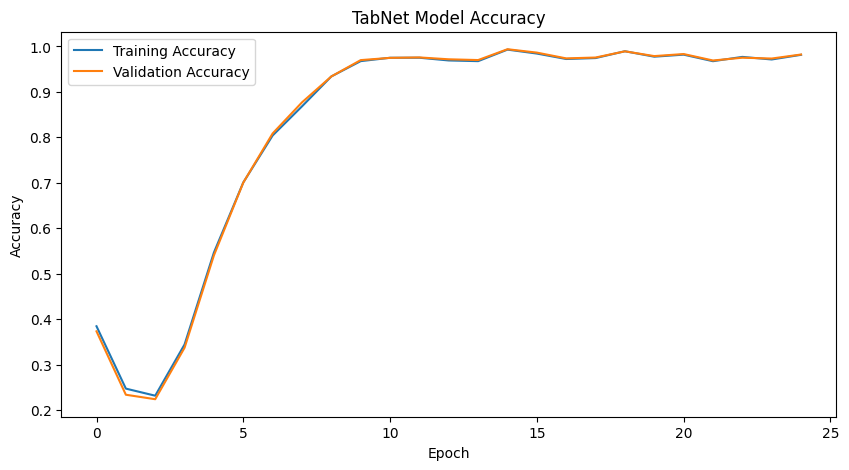

In [94]:
history = tabnet_model.history
train_accuracy = history['train_accuracy']
val_accuracy = history['valid_accuracy']
train_loss = history['loss']

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('TabNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
model_results = {
    'Logistic Regression': accuracy_score(y_val, y_pred_log_reg),
    'Random Forest': accuracy_score(y_val, y_pred_rf),
    'SVM': accuracy_score(y_val, y_pred_svm),
    'XGBoost': accuracy_score(y_val, y_pred_xgb),
    'TabNet': accuracy_score(y_test, y_pred_tabnet)
}

results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
print("Model Comparison:")
print(results_df)

Model Comparison:
                     Accuracy
Logistic Regression  0.916080
Random Forest        1.000000
SVM                  0.997374
XGBoost              0.998214
TabNet               0.993909
